<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = True
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'

# from google.colab import drive
# drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [152]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [153]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [154]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [155]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [156]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [157]:
def get_weights(increment = 2.0):

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1



  weights[1] *= increment
  weights[3] *= increment
  weights[4] *= increment


  weights = weights / weights.sum()


  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]),weights

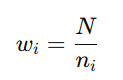

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [158]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [159]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 3:
    googlenet = models.googlenet(weights="IMAGENET1K_V1")
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 4:
    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn




In [160]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [161]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [162]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [163]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)
  architecrures_inv = {0: 'alexnet',1:'vgg',2:'resnet'}


  patiente = 15
  best_recall = 0

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

        # torch.save(model, "my_model.pt")
        # wandb.log_model("./my_model.pt", architecrures_inv[MODEL], aliases=[f"epoch-{epoch+1}"])

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if train_recall > best_recall:
        patiente = 15
        best_recall = train_recall
      else:
        patiente -= 1

      if patiente == 0:
        torch.save(model.state_dict(), 'best_model.pt')
        print("Early Stopping!!")
        break


  wandb.finish()

In [164]:
def test(model,dataloader,weights_dir,loss_fn,device):
  model.load_state_dict(torch.load(weights_dir))
  test_acc,test_f1,test_recall,test_precision,test_loss  = validate(model,loss_fn,dataloader,device)

  if WEIGHTSANDBIASES:
    test_metrics = {"test/test_loss": test_loss/len(dataloader),
                      "test/test_acc":test_acc/len(dataloader),
                      "test/test_f1":test_f1/len(dataloader),
                      "test/test_recall": test_recall/len(dataloader),
                      "test/test_precision": test_precision/len(dataloader)}

    wandb.log({**test_metrics})

In [165]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet': 1,'resnet152':2,'googlenet':3,'alexnetmulticlass':4}
MODEL = architectures['alexnetmulticlass']

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 100
batch_size = 32

#[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ]
# WEIGHTS = [[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
#  [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

#WEIGHTS = [2.33,1.5]

#get_weights()
increment = 1.0
binary_weights, multiple_weights = get_weights(increment)
WEIGHTS = [multiple_weights]
learning_rate  = 1e-5

for weights in product(WEIGHTS):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-ResnetBinary','Ham1000-Resnet152Binary','Ham10000-GoogleNetBinary','Ham10000-AlexnetMulticlass']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
  test(model,test_loader,"/content/best_model.pt",loss_fn,device)

0    5363
1     891
2     879
3     411
4     261
5     114
6      92
Name: count, dtype: int64
8011
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


{'epochs': 50, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [[0.0052145569997054594, 0.06282768137111429, 0.03181401700002284, 0.136045154408658, 0.2138446769603982, 0.24622256819031763, 0.30403134506978347]]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 1.539814242803718
Accuracy train epoch: 1  train_acc: 0.46741443317638537
F1 train epoch: 1  train_f1: 0.5147361444755559
Recall train epoch: 1  train_recall: 0.46741443317638537


Pèrdua validació epoch: 1  val_loss: 1.2359358370304108
Accuracy val epoch: 1  val_acc: 0.5443359375
F1 val epoch: 1  val_f1: 0.5942831386746981
Recall val epoch: 1  val_recall: 0.5443359375
Recall val epoch: 1  val_precision: 0.8090740953924548


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 1.1311962935197877
Accuracy train epoch: 2  train_acc: 0.5775873777616806
F1 train epoch: 2  train_f1: 0.6301855431079012
Recall train epoch: 2  train_recall: 0.5775873777616806


Pèrdua validació epoch: 2  val_loss: 1.1171694491058588
Accuracy val epoch: 2  val_acc: 0.6025390625
F1 val epoch: 2  val_f1: 0.6544948740335378
Recall val epoch: 2  val_recall: 0.6025390625
Recall val epoch: 2  val_precision: 0.8026360210140656


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.9656207245065871
Accuracy train epoch: 3  train_acc: 0.6099918507787033
F1 train epoch: 3  train_f1: 0.6595936079026475
Recall train epoch: 3  train_recall: 0.6099918507787033


Pèrdua validació epoch: 3  val_loss: 0.9427165230736136
Accuracy val epoch: 3  val_acc: 0.6439453125
F1 val epoch: 3  val_f1: 0.6894217858284246
Recall val epoch: 3  val_recall: 0.6439453125
Recall val epoch: 3  val_precision: 0.8273529421966921


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.8880220209934797
Accuracy train epoch: 4  train_acc: 0.6183448026077508
F1 train epoch: 4  train_f1: 0.6670945798766946
Recall train epoch: 4  train_recall: 0.6183448026077508


Pèrdua validació epoch: 4  val_loss: 0.952630179002881
Accuracy val epoch: 4  val_acc: 0.6484375
F1 val epoch: 4  val_f1: 0.6896758021956391
Recall val epoch: 4  val_recall: 0.6484375
Recall val epoch: 4  val_precision: 0.8075588163177201


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.812385233631172
Accuracy train epoch: 5  train_acc: 0.6366126403477
F1 train epoch: 5  train_f1: 0.6813289720886849
Recall train epoch: 5  train_recall: 0.6366126403477


Pèrdua validació epoch: 5  val_loss: 0.8935390766710043
Accuracy val epoch: 5  val_acc: 0.6380859375
F1 val epoch: 5  val_f1: 0.6838444559384362
Recall val epoch: 5  val_recall: 0.6380859375
Recall val epoch: 5  val_precision: 0.8312356979277361


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.7537789859501014
Accuracy train epoch: 6  train_acc: 0.6481913256066643
F1 train epoch: 6  train_f1: 0.6917081542520943
Recall train epoch: 6  train_recall: 0.6481913256066643


Pèrdua validació epoch: 6  val_loss: 0.8480858104303479
Accuracy val epoch: 6  val_acc: 0.687109375
F1 val epoch: 6  val_f1: 0.726003349668756
Recall val epoch: 6  val_recall: 0.687109375
Recall val epoch: 6  val_precision: 0.8473343843706682


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.7196347457004258
Accuracy train epoch: 7  train_acc: 0.6631428830134009
F1 train epoch: 7  train_f1: 0.7040933601885628
Recall train epoch: 7  train_recall: 0.6631428830134009


Pèrdua validació epoch: 7  val_loss: 0.7929247934371233
Accuracy val epoch: 7  val_acc: 0.6046875
F1 val epoch: 7  val_f1: 0.6557912027930345
Recall val epoch: 7  val_recall: 0.6046875
Recall val epoch: 7  val_precision: 0.8274755003026487


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.6911063536229837
Accuracy train epoch: 8  train_acc: 0.6698433538572981
F1 train epoch: 8  train_f1: 0.7089949253967452
Recall train epoch: 8  train_recall: 0.6698433538572981


Pèrdua validació epoch: 8  val_loss: 0.7840197887271643
Accuracy val epoch: 8  val_acc: 0.618359375
F1 val epoch: 8  val_f1: 0.667263286613885
Recall val epoch: 8  val_recall: 0.618359375
Recall val epoch: 8  val_precision: 0.8257141187805248


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.643697662330956
Accuracy train epoch: 9  train_acc: 0.6789659543643607
F1 train epoch: 9  train_f1: 0.7200248037517595
Recall train epoch: 9  train_recall: 0.6789659543643607


Pèrdua validació epoch: 9  val_loss: 0.807510825805366
Accuracy val epoch: 9  val_acc: 0.62109375
F1 val epoch: 9  val_f1: 0.6623904002022039
Recall val epoch: 9  val_recall: 0.62109375
Recall val epoch: 9  val_precision: 0.8439271754935757


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.5859447176237981
Accuracy train epoch: 10  train_acc: 0.6899221296631655
F1 train epoch: 10  train_f1: 0.7300597992960812
Recall train epoch: 10  train_recall: 0.6899221296631655


Pèrdua validació epoch: 10  val_loss: 0.7822395933326334
Accuracy val epoch: 10  val_acc: 0.6697265625
F1 val epoch: 10  val_f1: 0.711823960398683
Recall val epoch: 10  val_recall: 0.6697265625
Recall val epoch: 10  val_precision: 0.8523311494493079


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.576431661013113
Accuracy train epoch: 11  train_acc: 0.6957624049257515
F1 train epoch: 11  train_f1: 0.733273905740235
Recall train epoch: 11  train_recall: 0.6957624049257515


Pèrdua validació epoch: 11  val_loss: 0.775819472502917
Accuracy val epoch: 11  val_acc: 0.6435546875
F1 val epoch: 11  val_f1: 0.6923012107570078
Recall val epoch: 11  val_recall: 0.6435546875
Recall val epoch: 11  val_precision: 0.8535828131287118


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.5771316649073148
Accuracy train epoch: 12  train_acc: 0.7023723288663527
F1 train epoch: 12  train_f1: 0.7400398887857488
Recall train epoch: 12  train_recall: 0.7023723288663527


Pèrdua validació epoch: 12  val_loss: 0.8002621168270707
Accuracy val epoch: 12  val_acc: 0.7185546875
F1 val epoch: 12  val_f1: 0.7538684336292916
Recall val epoch: 12  val_recall: 0.7185546875
Recall val epoch: 12  val_precision: 0.855424649452728


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.5334886090451503
Accuracy train epoch: 13  train_acc: 0.7169390619340819
F1 train epoch: 13  train_f1: 0.7515741125583066
Recall train epoch: 13  train_recall: 0.7169390619340819


Pèrdua validació epoch: 13  val_loss: 0.7150929444469512
Accuracy val epoch: 13  val_acc: 0.7056640625
F1 val epoch: 13  val_f1: 0.7387616902631419
Recall val epoch: 13  val_recall: 0.7056640625
Recall val epoch: 13  val_precision: 0.8429217338506626


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.4828997152556936
Accuracy train epoch: 14  train_acc: 0.7231302064469395
F1 train epoch: 14  train_f1: 0.757158610389726
Recall train epoch: 14  train_recall: 0.7231302064469395


Pèrdua validació epoch: 14  val_loss: 0.7901471587829292
Accuracy val epoch: 14  val_acc: 0.722265625
F1 val epoch: 14  val_f1: 0.7548259350954996
Recall val epoch: 14  val_recall: 0.722265625
Recall val epoch: 14  val_precision: 0.850735609434083


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.47012330478880987
Accuracy train epoch: 15  train_acc: 0.7388061390800434
F1 train epoch: 15  train_f1: 0.7707644644600917
Recall train epoch: 15  train_recall: 0.7388061390800434


Pèrdua validació epoch: 15  val_loss: 0.751692118588835
Accuracy val epoch: 15  val_acc: 0.7439453125
F1 val epoch: 15  val_f1: 0.7764136748529207
Recall val epoch: 15  val_recall: 0.7439453125
Recall val epoch: 15  val_precision: 0.851325704492352


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.4312257837964244
Accuracy train epoch: 16  train_acc: 0.7439333574791742
F1 train epoch: 16  train_f1: 0.77520041390163
Recall train epoch: 16  train_recall: 0.7439333574791742


Pèrdua validació epoch: 16  val_loss: 0.8082053484395146
Accuracy val epoch: 16  val_acc: 0.695703125
F1 val epoch: 16  val_f1: 0.7334207675145514
Recall val epoch: 16  val_recall: 0.695703125
Recall val epoch: 16  val_precision: 0.8463148192781725


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.4339304290622829
Accuracy train epoch: 17  train_acc: 0.7429599782687432
F1 train epoch: 17  train_f1: 0.7734439561244687
Recall train epoch: 17  train_recall: 0.7429599782687432


Pèrdua validació epoch: 17  val_loss: 0.7442358322441578
Accuracy val epoch: 17  val_acc: 0.7158203125
F1 val epoch: 17  val_f1: 0.7546721875418136
Recall val epoch: 17  val_recall: 0.7158203125
Recall val epoch: 17  val_precision: 0.852065025267795


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.4015624750539126
Accuracy train epoch: 18  train_acc: 0.7593602861282144
F1 train epoch: 18  train_f1: 0.7876397780860954
Recall train epoch: 18  train_recall: 0.7593602861282144


Pèrdua validació epoch: 18  val_loss: 0.7634791238233447
Accuracy val epoch: 18  val_acc: 0.6904296875
F1 val epoch: 18  val_f1: 0.7281960238939112
Recall val epoch: 18  val_recall: 0.6904296875
Recall val epoch: 18  val_precision: 0.8533537799134074


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.3841064628436271
Accuracy train epoch: 19  train_acc: 0.7609674936617168
F1 train epoch: 19  train_f1: 0.7885463496213055
Recall train epoch: 19  train_recall: 0.7609674936617168


Pèrdua validació epoch: 19  val_loss: 0.7938532917760313
Accuracy val epoch: 19  val_acc: 0.740625
F1 val epoch: 19  val_f1: 0.7712953866987619
Recall val epoch: 19  val_recall: 0.740625
Recall val epoch: 19  val_precision: 0.8598078668394192


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.3749808386205677
Accuracy train epoch: 20  train_acc: 0.7688337558855487
F1 train epoch: 20  train_f1: 0.7974293983536801
Recall train epoch: 20  train_recall: 0.7688337558855487


Pèrdua validació epoch: 20  val_loss: 0.7743628565222025
Accuracy val epoch: 20  val_acc: 0.74765625
F1 val epoch: 20  val_f1: 0.7747860649156085
Recall val epoch: 20  val_recall: 0.74765625
Recall val epoch: 20  val_precision: 0.85871606141956


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.36689167122441935
Accuracy train epoch: 21  train_acc: 0.7777752625860196
F1 train epoch: 21  train_f1: 0.8051963036737354
Recall train epoch: 21  train_recall: 0.7777752625860196


Pèrdua validació epoch: 21  val_loss: 0.7458622986450791
Accuracy val epoch: 21  val_acc: 0.74296875
F1 val epoch: 21  val_f1: 0.7720756818075141
Recall val epoch: 21  val_recall: 0.74296875
Recall val epoch: 21  val_precision: 0.8584100430787301


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.3539226097295959
Accuracy train epoch: 22  train_acc: 0.7788957805143064
F1 train epoch: 22  train_f1: 0.8055929349450437
Recall train epoch: 22  train_recall: 0.7788957805143064


Pèrdua validació epoch: 22  val_loss: 0.7688239109702408
Accuracy val epoch: 22  val_acc: 0.7388671875
F1 val epoch: 22  val_f1: 0.7754097998365983
Recall val epoch: 22  val_recall: 0.7388671875
Recall val epoch: 22  val_precision: 0.8713584796451266


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.34703008023153736
Accuracy train epoch: 23  train_acc: 0.7807519920318725
F1 train epoch: 23  train_f1: 0.807451113680539
Recall train epoch: 23  train_recall: 0.7807519920318725


Pèrdua validació epoch: 23  val_loss: 0.77423752611503
Accuracy val epoch: 23  val_acc: 0.763671875
F1 val epoch: 23  val_f1: 0.7858524348143022
Recall val epoch: 23  val_recall: 0.763671875
Recall val epoch: 23  val_precision: 0.8546822346622879


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.32033424733941296
Accuracy train epoch: 24  train_acc: 0.7879957442955451
F1 train epoch: 24  train_f1: 0.8133633185204471
Recall train epoch: 24  train_recall: 0.7879957442955451


Pèrdua validació epoch: 24  val_loss: 0.8484024205245078
Accuracy val epoch: 24  val_acc: 0.723046875
F1 val epoch: 24  val_f1: 0.7512216641238366
Recall val epoch: 24  val_recall: 0.723046875
Recall val epoch: 24  val_precision: 0.8516043226718065


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.30269534801285103
Accuracy train epoch: 25  train_acc: 0.7959978268743209
F1 train epoch: 25  train_f1: 0.8209094202823063
Recall train epoch: 25  train_recall: 0.7959978268743209


Pèrdua validació epoch: 25  val_loss: 0.8236233363859355
Accuracy val epoch: 25  val_acc: 0.718359375
F1 val epoch: 25  val_f1: 0.7472481129127012
Recall val epoch: 25  val_recall: 0.718359375
Recall val epoch: 25  val_precision: 0.8550565074928577


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.3098186496422585
Accuracy train epoch: 26  train_acc: 0.7907234697573343
F1 train epoch: 26  train_f1: 0.8152417247031397
Recall train epoch: 26  train_recall: 0.7907234697573343


Pèrdua validació epoch: 26  val_loss: 0.7670545354485512
Accuracy val epoch: 26  val_acc: 0.6884765625
F1 val epoch: 26  val_f1: 0.7253560409652776
Recall val epoch: 26  val_recall: 0.6884765625
Recall val epoch: 26  val_precision: 0.8579532766965494


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.30088827494843545
Accuracy train epoch: 27  train_acc: 0.790995110467222
F1 train epoch: 27  train_f1: 0.8167260911502744
Recall train epoch: 27  train_recall: 0.790995110467222


Pèrdua validació epoch: 27  val_loss: 0.7741891373880208
Accuracy val epoch: 27  val_acc: 0.7599609375
F1 val epoch: 27  val_f1: 0.7864127018853708
Recall val epoch: 27  val_recall: 0.7599609375
Recall val epoch: 27  val_precision: 0.8615321983426333


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.29194606238033666
Accuracy train epoch: 28  train_acc: 0.8064559942049981
F1 train epoch: 28  train_f1: 0.8296202517797946
Recall train epoch: 28  train_recall: 0.8064559942049981


Pèrdua validació epoch: 28  val_loss: 0.7998939887620509
Accuracy val epoch: 28  val_acc: 0.753515625
F1 val epoch: 28  val_f1: 0.7827793066100764
Recall val epoch: 28  val_recall: 0.753515625
Recall val epoch: 28  val_precision: 0.8656460421168195


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.2760761039131191
Accuracy train epoch: 29  train_acc: 0.8162350597609562
F1 train epoch: 29  train_f1: 0.8389946531415258
Recall train epoch: 29  train_recall: 0.8162350597609562


Pèrdua validació epoch: 29  val_loss: 0.7631047738250345
Accuracy val epoch: 29  val_acc: 0.7583984375
F1 val epoch: 29  val_f1: 0.7809254232670617
Recall val epoch: 29  val_recall: 0.7583984375
Recall val epoch: 29  val_precision: 0.8550368222510794


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.2768464327986497
Accuracy train epoch: 30  train_acc: 0.8084253893516842
F1 train epoch: 30  train_f1: 0.8317175866591691
Recall train epoch: 30  train_recall: 0.8084253893516842


Pèrdua validació epoch: 30  val_loss: 0.904011026956141
Accuracy val epoch: 30  val_acc: 0.7533203125
F1 val epoch: 30  val_f1: 0.7815943715874694
Recall val epoch: 30  val_recall: 0.7533203125
Recall val epoch: 30  val_precision: 0.859698288481901


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.2566281571331252
Accuracy train epoch: 31  train_acc: 0.8126471387178559
F1 train epoch: 31  train_f1: 0.8345804625913413
Recall train epoch: 31  train_recall: 0.8126471387178559


Pèrdua validació epoch: 31  val_loss: 0.7436436100397259
Accuracy val epoch: 31  val_acc: 0.7720703125
F1 val epoch: 31  val_f1: 0.7910439608216927
Recall val epoch: 31  val_recall: 0.7720703125
Recall val epoch: 31  val_precision: 0.8593302976016836


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.24511304009423787
Accuracy train epoch: 32  train_acc: 0.8180007243752263
F1 train epoch: 32  train_f1: 0.8393053788516391
Recall train epoch: 32  train_recall: 0.8180007243752263


Pèrdua validació epoch: 32  val_loss: 0.8400065908208489
Accuracy val epoch: 32  val_acc: 0.762109375
F1 val epoch: 32  val_f1: 0.7868349335012401
Recall val epoch: 32  val_recall: 0.762109375
Recall val epoch: 32  val_precision: 0.8621883822618059


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.2327064447906388
Accuracy train epoch: 33  train_acc: 0.8279608837377761
F1 train epoch: 33  train_f1: 0.8480721190633538
Recall train epoch: 33  train_recall: 0.8279608837377761


Pèrdua validació epoch: 33  val_loss: 0.8291854076087475
Accuracy val epoch: 33  val_acc: 0.75703125
F1 val epoch: 33  val_f1: 0.7836942615706799
Recall val epoch: 33  val_recall: 0.75703125
Recall val epoch: 33  val_precision: 0.8530086895322946


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.2350023304412802
Accuracy train epoch: 34  train_acc: 0.8235806772908366
F1 train epoch: 34  train_f1: 0.8439148112815783
Recall train epoch: 34  train_recall: 0.8235806772908366


Pèrdua validació epoch: 34  val_loss: 0.8029966023750603
Accuracy val epoch: 34  val_acc: 0.7810546875
F1 val epoch: 34  val_f1: 0.8001316275838506
Recall val epoch: 34  val_recall: 0.7810546875
Recall val epoch: 34  val_precision: 0.8561821298246172


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.2258068672659625
Accuracy train epoch: 35  train_acc: 0.8321826331039478
F1 train epoch: 35  train_f1: 0.8521854456205771
Recall train epoch: 35  train_recall: 0.8321826331039478


Pèrdua validació epoch: 35  val_loss: 1.0079393801279366
Accuracy val epoch: 35  val_acc: 0.7486328125
F1 val epoch: 35  val_f1: 0.7735903635544134
Recall val epoch: 35  val_recall: 0.7486328125
Recall val epoch: 35  val_precision: 0.8622164173517224


Batches (Època 36): 0it [00:00, ?it/s]

KeyboardInterrupt: 